In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
from transformers import pipeline
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
!pip install datasets
from datasets import Dataset, DatasetDict
import torch
from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Cargo los datos en DataFrames
file_path_train= r'/content/train.txt'
file_path_val= r'/content/val.txt'
file_path_test= r'/content/test.txt'

train_df = pd.read_csv(file_path_train, delimiter=';')
val_df = pd.read_csv(file_path_val, delimiter=';')
test_df = pd.read_csv(file_path_test, delimiter=';')


In [ ]:
# Le asigno nombres a las columnas del porque no tiene
train_df.columns = ['frase', 'sentimiento']
val_df.columns = ['frase', 'sentimiento']
test_df.columns = ['frase', 'sentimiento']


# Recortar los conjuntos de datos a la mitad para que la duracion del entrenamiento sea menor
train_df = train_df.sample(frac=0.5, random_state=42)  # Reducir al 50%
val_df = val_df.sample(frac=0.5, random_state=42)      # Reducir al 50%
test_df = test_df.sample(frac=0.5, random_state=42)    # Reducir al 50%

In [ ]:
# Mapear las etiquetas a números porque modelos de BERT para clasificación de secuencias esperan que las etiquetas de salida sean valores numéricos, no texto.
label2id = {label: i for i, label in enumerate(train_df['sentimiento'].unique())}
id2label = {i: label for label, i in label2id.items()}

train_df['sentimiento'] = train_df['sentimiento'].map(label2id)
val_df['sentimiento'] = val_df['sentimiento'].map(label2id)
test_df['sentimiento'] = test_df['sentimiento'].map(label2id)

# Convierto los DataFrames a Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Crear DatasetDict
datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

## **Reviso que los datasets esten correctos y tengan bien la informacion.**

---



In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['frase', 'sentimiento', '__index_level_0__'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['frase', 'sentimiento', '__index_level_0__'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['frase', 'sentimiento', '__index_level_0__'],
        num_rows: 1000
    })
})

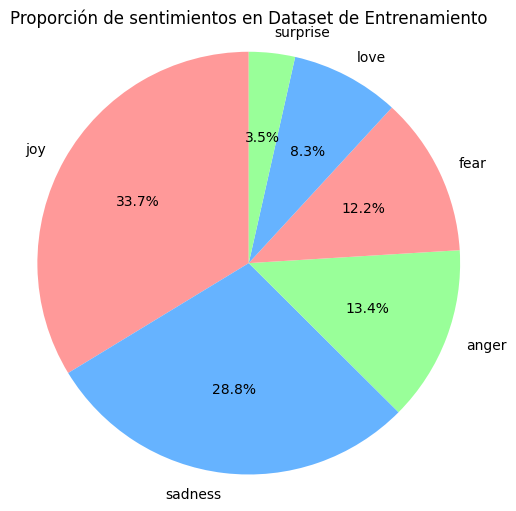

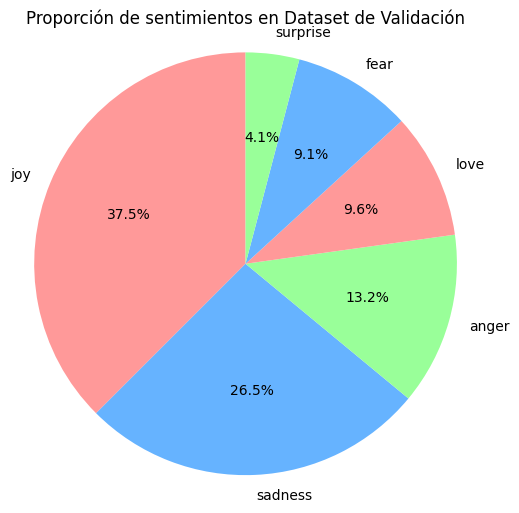

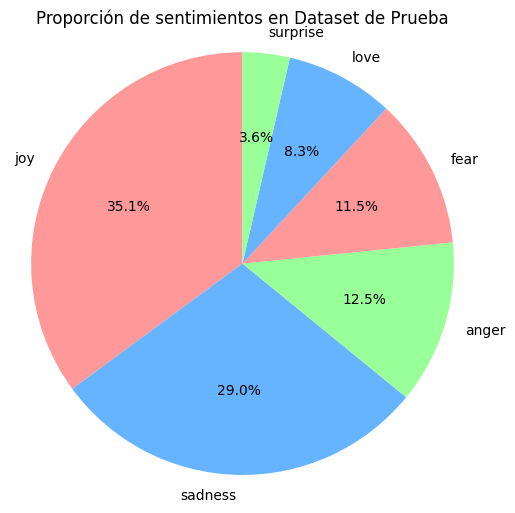

In [ ]:
#Hago graficos para ver la distribucion de los sentimientos en cada uno de los datasets

def crear_grafico_torta(df, dataset_name, id2label):


    sentimiento_counts = df['sentimiento'].value_counts()

    # Vuelvo a convertir los números a sus etiquetas correspondientes
    labels = [id2label[i] for i in sentimiento_counts.index]

    plt.figure(figsize=(6,6))
    plt.pie(sentimiento_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(f'Proporción de sentimientos en {dataset_name}')
    plt.axis('equal')
    plt.show()

# Crear gráficos de torta para cada dataset
crear_grafico_torta(train_df, "Dataset de Entrenamiento", id2label)
crear_grafico_torta(val_df, "Dataset de Validación", id2label)
crear_grafico_torta(test_df, "Dataset de Prueba", id2label)

## **Se realiza la tokenizacion**

In [ ]:
# Cargar el modelo y el tokenizador
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función de tokenización con etiquetas
def tokenize_function(examples):
    # Tokenización y agregar las etiquetas al resultado
    result = tokenizer(examples['frase'], padding='max_length', truncation=True)
    result['labels'] = examples['sentimiento']  # Añadir las etiquetas (labels)
    return result

# Aplicar tokenización
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Me aseguro de que el dataset tenga las columnas correctas
print(tokenized_datasets['train'].features)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'frase': Value(dtype='string', id=None), 'sentimiento': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


## **Cargo el modelo**

In [ ]:
# Función para calcular las métricas usando scikit-learn
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
# Se definen los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Se crea el objeto Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,  # Asegurar que el tokenizador se incluya en el trainer
    compute_metrics=compute_metrics
)


In [ ]:
# Se inicia el entrenamiento
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.509400,0.274972,0.922000
2,0.206900,0.241930,0.929000


TrainOutput(global_step=2000, training_loss=0.4039930832982063, metrics={'train_runtime': 1572.9593, 'train_samples_per_second': 10.172, 'train_steps_per_second': 1.271, 'total_flos': 4209928077312000.0, 'train_loss': 0.4039930832982063, 'epoch': 2.0})

aaaaa


## **Evaluacion del modelo**

In [ ]:
# Se evalua el modelo en el conjunto de validación

eval_result = trainer.evaluate()

# Imprimir los resultados
print(f"Resultados de evaluación: {eval_result}")

Resultados de evaluación: {'eval_loss': 0.24192972481250763, 'eval_accuracy': 0.929, 'eval_runtime': 27.804, 'eval_samples_per_second': 35.966, 'eval_steps_per_second': 4.496, 'epoch': 2.0}


**El valor de 0.24 indica que el modelo tiene un error bajo.
El accuracy esta en un nivel muy bueno ya que el 92.9% de las predicciones fueron correctas.**



## **Algunas otras evaluaciones**

In [ ]:
# Detectar si hay una GPU disponible y mover el modelo al dispositivo adecuado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Frases nuevas para predecir el sentimiento
nuevas_frases = ["I am very happy", "I am tired today", "It is not a happy day"]

# Tokenizar las nuevas frases y moverlas al mismo dispositivo
inputs = tokenizer(nuevas_frases, padding='max_length', truncation=True, return_tensors='pt').to(device)

# Hacer predicciones con el modelo en el dispositivo correcto
outputs = model(**inputs)
logits = outputs.logits

# Obtener las predicciones
predicciones = torch.argmax(logits, dim=-1)

# Mapear de vuelta a las etiquetas de sentimiento
predicciones_etiquetas = [id2label[p.item()] for p in predicciones]

# Imprimir resultados
print(f"Frases: {nuevas_frases}")
print(f"Predicciones: {predicciones_etiquetas}")


Frases: ['I am very happy', 'I am tired today', 'It is not a happy day']
Predicciones: ['joy', 'sadness', 'joy']


In [ ]:
# Se evalua los casos en los que el modelo falló


predicciones3 = trainer.predict(tokenized_datasets['validation'])

pred_labels = np.argmax(predicciones3.predictions, axis=-1)
true_labels = predicciones3.label_ids

errores = [(true, pred) for true, pred in zip(true_labels, pred_labels) if true != pred]
print(f"Errores de predicción: {errores}")


Errores de predicción: [(0, 1), (3, 4), (3, 5), (3, 4), (3, 2), (3, 4), (2, 1), (1, 0), (1, 2), (4, 3), (4, 3), (3, 4), (4, 3), (4, 3), (0, 5), (0, 1), (4, 3), (3, 1), (0, 5), (3, 2), (4, 2), (3, 4), (3, 4), (2, 0), (5, 0), (2, 1), (3, 1), (1, 3), (4, 3), (0, 2), (1, 3), (3, 2), (0, 2), (1, 2), (2, 4), (5, 2), (1, 2), (1, 3), (3, 4), (2, 3), (3, 5), (0, 2), (5, 3), (3, 4), (2, 3), (3, 4), (0, 5), (2, 1), (4, 3), (3, 4), (0, 1), (3, 0), (4, 3), (4, 2), (3, 4), (4, 3), (4, 3), (0, 2), (3, 4), (4, 2), (1, 0), (0, 1), (0, 1), (0, 5), (1, 0), (3, 4), (3, 2), (4, 3), (2, 4), (0, 2), (3, 5)]
